# 의료용 마스크 탐지 모델 구축 : Faster R-CNN

In [1]:
import torch

if torch.cuda.is_available():    
    device = torch.device("cuda")
    print('There are %d GPU(s) available.' % torch.cuda.device_count())
    print('We will use the GPU:', torch.cuda.get_device_name(0))

else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")

There are 2 GPU(s) available.
We will use the GPU: Tesla V100-SXM2-32GB


In [2]:
import os
import numpy as np
import matplotlib.patches as patches
import matplotlib.pyplot as plt
from bs4 import BeautifulSoup
from PIL import Image
import torchvision
from torchvision import transforms, datasets, models
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
import time

## Data Set Class 정의

In [3]:
def generate_box(obj):
    
    xmin = float(obj.find('xmin').text)
    ymin = float(obj.find('ymin').text)
    xmax = float(obj.find('xmax').text)
    ymax = float(obj.find('ymax').text)
    
    return [xmin, ymin, xmax, ymax]

adjust_label = 1

In [4]:
def generate_label(obj):

    if obj.find('name').text == "with_mask":

        return 1 + adjust_label

    elif obj.find('name').text == "mask_weared_incorrect":

        return 2 + adjust_label

    return 0 + adjust_label

In [5]:
def generate_target(file): 
    with open(file) as f:
        data = f.read()
        soup = BeautifulSoup(data, "html.parser")
        objects = soup.find_all("object")

        num_objs = len(objects)

        boxes = []
        labels = []
        for i in objects:
            boxes.append(generate_box(i))
            labels.append(generate_label(i))

        boxes = torch.as_tensor(boxes, dtype=torch.float32) 
        labels = torch.as_tensor(labels, dtype=torch.int64) 
        
        target = {}
        target["boxes"] = boxes
        target["labels"] = labels
        
        return target

In [6]:
def plot_image_from_output(img, annotation):
    
    img = img.cpu().permute(1,2,0)
    
    fig,ax = plt.subplots(1)
    ax.imshow(img)
    
    for idx in range(len(annotation["boxes"])):
        xmin, ymin, xmax, ymax = annotation["boxes"][idx]

        if annotation['labels'][idx] == 1 :
            rect = patches.Rectangle((xmin,ymin),(xmax-xmin),(ymax-ymin),linewidth=1,edgecolor='r',facecolor='none')
        
        elif annotation['labels'][idx] == 2 :
            
            rect = patches.Rectangle((xmin,ymin),(xmax-xmin),(ymax-ymin),linewidth=1,edgecolor='g',facecolor='none')
            
        else :
        
            rect = patches.Rectangle((xmin,ymin),(xmax-xmin),(ymax-ymin),linewidth=1,edgecolor='orange',facecolor='none')

        ax.add_patch(rect)

    plt.show()

In [7]:
class MaskDataset(object):
    def __init__(self, transforms, path):
        '''
        path: path to train folder or test folder
        '''
        # transform module과 img path 경로를 정의
        self.transforms = transforms
        self.path = path
        self.imgs = list(sorted(os.listdir(self.path)))


    def __getitem__(self, idx): #special method
        # load images ad masks
        file_image = self.imgs[idx]
        file_label = self.imgs[idx][:-3] + 'xml'
        img_path = os.path.join(self.path, file_image)
        
        if 'test' in self.path:
            label_path = os.path.join("test_annotations/", file_label)
        else:
            label_path = os.path.join("annotations/", file_label)

        img = Image.open(img_path).convert("RGB")
        #Generate Label
        target = generate_target(label_path)
        
        if self.transforms is not None:
            img = self.transforms(img)

        return img, target

    def __len__(self): 
        return len(self.imgs)

data_transform = transforms.Compose([  # transforms.Compose : list 내의 작업을 연달아 할 수 있게 호출하는 클래스
        transforms.ToTensor() # ToTensor : numpy 이미지에서 torch 이미지로 변경
    ])

def collate_fn(batch):
    return tuple(zip(*batch))

dataset = MaskDataset(data_transform, 'images/')
test_dataset = MaskDataset(data_transform, 'test_images/')

data_loader = torch.utils.data.DataLoader(dataset, batch_size=4, collate_fn=collate_fn)
test_data_loader = torch.utils.data.DataLoader(test_dataset, batch_size=2, collate_fn=collate_fn)

## 모델 불러오기

torchvision.models.detection에서는 Faster R-CNN API(torchvision.models.detection.fasterrcnn_resnet50_fpn)를 제공하고 있어 쉽게 구현이 가능. 이는 COCO 데이터셋을 ResNet50으로 pre-trained한 모델을 제공하고 있으며, pretrained=True/False로 설정할 수 있다.

이후 모델을 불러올 때는 num_classes에 원하는 클래스 개수를 설정하고 모델을 사용하면 됨.  
Faster R-CNN 사용 시 주의할 점은 background 클래스를 포함한 개수를 num_classes에 명시해야 한다. 즉, 실제 데이터셋의 클래스 개수에 1개를 늘려 background 클래스를 추가해야 한다.

In [8]:
def get_model_instance_segmentation(num_classes):
  
    model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

    return model

## 전이 학습

Face Mask Detection 데이터셋은 3개의 클래스로 이루어져 있지만 background 클래스를 포함하여 num_classes를 4로 설정한 후 모델을 불러온다.

In [9]:
model = get_model_instance_segmentation(4)

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu') 
model.to(device)

Downloading: "https://download.pytorch.org/models/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth" to /home/ubuntu/.cache/torch/hub/checkpoints/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth


FasterRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256)
          (relu): ReLU(inplace=True)
          (downsample)

In [10]:
# gpu 사용 가능 여부

torch.cuda.is_available()

True

In [11]:
num_epochs = 10
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.005,
                                momentum=0.9, weight_decay=0.0005)

In [12]:
print('----------------------train start--------------------------')
for epoch in range(num_epochs):
    start = time.time()
    model.train()
    i = 0    
    epoch_loss = 0
    for imgs, annotations in data_loader:
        i += 1
        imgs = list(img.to(device) for img in imgs)
        annotations = [{k: v.to(device) for k, v in t.items()} for t in annotations]
        loss_dict = model(imgs, annotations) 
        losses = sum(loss for loss in loss_dict.values())        

        optimizer.zero_grad()
        losses.backward()
        optimizer.step() 
        epoch_loss += losses
    print(f'epoch : {epoch+1}, Loss : {epoch_loss}, time : {time.time() - start}')

----------------------train start--------------------------
epoch : 1, Loss : 76.81654357910156, time : 184.53051352500916
epoch : 2, Loss : 49.413909912109375, time : 183.8826084136963
epoch : 3, Loss : 42.04747772216797, time : 183.63907098770142
epoch : 4, Loss : 35.1938362121582, time : 184.5205202102661
epoch : 5, Loss : 32.639381408691406, time : 184.1869921684265
epoch : 6, Loss : 31.81240463256836, time : 107.05670738220215
epoch : 7, Loss : 31.539339065551758, time : 79.09935641288757
epoch : 8, Loss : 29.251619338989258, time : 79.14204025268555
epoch : 9, Loss : 24.434215545654297, time : 78.99238324165344
epoch : 10, Loss : 23.979665756225586, time : 79.08561062812805


In [13]:
torch.save(model.state_dict(),f'model_{num_epochs}.pt')

In [14]:
model.load_state_dict(torch.load(f'model_{num_epochs}.pt'))

<All keys matched successfully>

## 예측

예측결과에는 바운딩 박스의 좌표(boxes)와 클래스(labels), 점수(scores)가 포함.   
점수(scores)에는 해당 클래스의 신뢰도 값이 저장되는데 threshold로 0.5 이상인 것만 추출하도록 함수make_prediction를 정의.  
test_data_loader의 첫번째 배치에 대해서만 결과를 출력

In [15]:
def make_prediction(model, img, threshold):
    model.eval()
    preds = model(img)
    for id in range(len(preds)) :
        idx_list = []

        for idx, score in enumerate(preds[id]['scores']) :
            if score > threshold : 
                idx_list.append(idx)

        preds[id]['boxes'] = preds[id]['boxes'][idx_list]
        preds[id]['labels'] = preds[id]['labels'][idx_list]
        preds[id]['scores'] = preds[id]['scores'][idx_list]

    return preds

In [16]:
with torch.no_grad(): 
    # 테스트셋 배치사이즈= 2
    for imgs, annotations in test_data_loader:
        imgs = list(img.to(device) for img in imgs)

        pred = make_prediction(model, imgs, 0.5)
        print(pred)
        break

[{'boxes': tensor([[214.5291,  59.6221, 250.2635, 101.5699],
        [118.3414,   2.9367, 132.4378,  18.2068]], device='cuda:0'), 'labels': tensor([2, 2], device='cuda:0'), 'scores': tensor([0.9613, 0.9322], device='cuda:0')}, {'boxes': tensor([[219.5754,  99.1420, 256.6555, 139.8848],
        [131.5161, 109.1106, 175.5934, 154.0274],
        [166.5933,  90.8849, 178.5611, 107.7561],
        [ 84.4072,  84.8052,  93.6579,  96.7355],
        [ 42.2069, 108.6500,  66.0016, 140.7146],
        [ 30.0527,  89.3683,  44.8889, 103.8634],
        [304.0351, 130.9926, 331.1382, 158.4525],
        [  4.0113, 104.5277,  21.5292, 127.0189],
        [258.2841,  91.8076, 268.2612, 101.6970]], device='cuda:0'), 'labels': tensor([2, 2, 1, 1, 1, 1, 1, 1, 1], device='cuda:0'), 'scores': tensor([0.9927, 0.9875, 0.9773, 0.9763, 0.9728, 0.9614, 0.9549, 0.8658, 0.6766],
       device='cuda:0')}]


예측된 결과를 이용해 이미지 위에 바운딩 박스를 그린다.  
Target이 실제 바운딩 박스 위치이며, Prediction이 모델의 예측 결과.

Target :  tensor([1, 1, 1, 2, 2, 1, 1, 1])


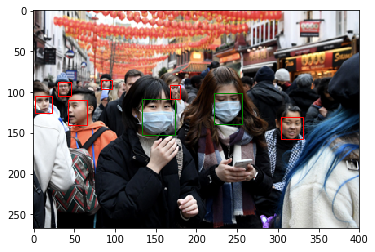

Prediction :  tensor([2, 2, 1, 1, 1, 1, 1, 1, 1], device='cuda:0')


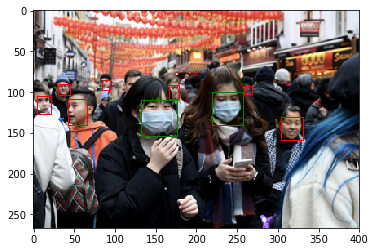

In [17]:
_idx = 1
print("Target : ", annotations[_idx]['labels'])
plot_image_from_output(imgs[_idx], annotations[_idx])
print("Prediction : ", pred[_idx]['labels'])
plot_image_from_output(imgs[_idx], pred[_idx])

시험 데이터에 대해 예측 결과를 평가

In [18]:
from tqdm import tqdm

labels = []
preds_adj_all = []
annot_all = []

for im, annot in tqdm(test_data_loader, position = 0, leave = True):
    im = list(img.to(device) for img in im)
    #annot = [{k: v.to(device) for k, v in t.items()} for t in annot]

    for t in annot:
        labels += t['labels']

    with torch.no_grad():
        preds_adj = make_prediction(model, im, 0.5)
        preds_adj = [{k: v.to(torch.device('cpu')) for k, v in t.items()} for t in preds_adj]
        preds_adj_all.append(preds_adj)
        annot_all.append(annot)

100%|██████████| 85/85 [00:12<00:00,  6.61it/s]


Tutorial-Book-Utils 폴더 내에 있는 utils_ObjectDetection.py 파일을 통해서 mAP 값을 산출.   
get_batch_statistics 함수를 통해 IoU(Intersection of Union) 조건을 만족하는 bounding box간의 통곗값을 계산후 ap_per_class 함수를 통해 각 클래스에 대한 AP값을 계산

In [19]:
%cd Tutorial-Book-Utils/
import utils_ObjectDetection as utils

/home/ubuntu/CUAI_2021/HayunLEE/Tutorial-Book-Utils


In [20]:
sample_metrics = []
for batch_i in range(len(preds_adj_all)):
    sample_metrics += utils.get_batch_statistics(preds_adj_all[batch_i], annot_all[batch_i], iou_threshold=0.5) 

true_positives, pred_scores, pred_labels = [torch.cat(x, 0) for x in list(zip(*sample_metrics))]  # 배치가 전부 합쳐짐
precision, recall, AP, f1, ap_class = utils.ap_per_class(true_positives, pred_scores, pred_labels, torch.tensor(labels))
mAP = torch.mean(AP)
print(f'mAP : {mAP}')
print(f'AP : {AP}')

mAP : 0.6882942348978697
AP : tensor([0.8455, 0.9116, 0.3077], dtype=torch.float64)


AP값은 background 클래스를 제외한 실제 3개의 클래스에 대해서만 보여줌.   
4장의 RetinaNet 결과보다 향상된 것을 확인할 수 있다.